In [39]:
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

SyntaxError: invalid syntax (<ipython-input-39-b96d5b6230f0>, line 1)

# Tendency budgets in regridded vertical coordinates

In [23]:
import xarray as xr
from matplotlib import pyplot as plt
import budgetcalcs as bc
from xhistogram.xarray import histogram
import numpy as np
import cartopy.crs as ccrs

In [2]:
rootdir = '/archive/gam/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/history/'
filename_native = '08990101.ocean_daily.nc'
filename_rho2 = '08990101.ocean_daily_rho2.nc'
filename_z = '08990101.ocean_daily_z.nc'
filename_grid = '08990101.ocean_static_no_mask_table.nc'
ds_native = xr.open_dataset(rootdir+filename_native,decode_times=False).isel(time=0)
ds_rho2 = xr.open_dataset(rootdir+filename_rho2,decode_times=False).isel(time=0)
ds_z = xr.open_dataset(rootdir+filename_z,decode_times=False).isel(time=0)
grid = xr.open_dataset(rootdir+filename_grid)

In [3]:
# Calculate the budgets, evaluate errors, merge to datasets
terms = ['T_advection_xy','Th_tendency_vert_remap','boundary_forcing_heat_tendency','internal_heat_heat_tendency','opottempdiff','opottemppmdiff','frazil_heat_tendency']
tend = 'opottemptend'
# Native
tendsum_native,error_native = bc.calc_budget(ds_native,terms,tend,vertc='zl',plot=False)
tendsum_native.name = 'tendsum'
error_native.name = 'error'
ds_native = xr.merge([ds_native,tendsum_native,error_native])
# Diagnostic
# rho2
tendsum_rho2,error_rho2 = bc.calc_budget(ds_rho2,terms,tend,vertc='rho2_l',plot=False)
tendsum_rho2.name = 'tendsum'
error_rho2.name = 'error'
ds_rho2 = xr.merge([ds_rho2,tendsum_rho2,error_rho2])
# z
tendsum_z,error_z = bc.calc_budget(ds_z,terms,tend,vertc='z_l',plot=False)
tendsum_z.name = 'tendsum'
error_z.name = 'error'
ds_z = xr.merge([ds_z,tendsum_z,error_z])

### Compare budget closure in native and diagnostic grids
#### What is being plotted?  
The following figures are shown below for both a single profile and a layer-wise global integral.
##### Figure 1.  
**(left panel)** The vertical cumulative integral of (black markers) the eulerian tendencies and (gray lines) the sum of the individual tendencies from (.) the native grid, (x) the rho2 grid (offset by constant value), and (+) the z grid (offset by constant value). This is plotted against vertical cumulative integral (surface to bottom) of layer thickess, i.e. depth (when single profile) or volume (when global integral is taken). **(middle panel)** The vertical cumulative integral (surface to bottom) of the budget "error" (eulerian tendency minus sum of individual tendencies).  It is plotted for the native grid budget (blue), and the diagnostic grid budgets (orange, green). **(right panel)** The difference between the native grid budget and the diagnostic grid(s) budget.  
##### Figure 2.
The difference between the native grid and diagnostic grid for each of the budget terms (including the eulerian tendency). The difference for each term sums up to the total error from Figure 1.

#### What does it show?
For a single profile, the budgets on both the z and the rho2 looks close to being closed, with slight errors emerging in the surface that effectively cancel out as the terms are integrated in the vertical. This indicates that there is a "misplacement" of tendencies between layers, resulting in non-closure within layers but with a column-integrated error of ~0 (constrained to be such by interpolation procedure). The misfitss for each tendency between the native and diagnostic grids can be used to determine which terms contribute to this error. In the single profile considered here, the error in both of the diagnostic grids is due to misplacement of the eulerian tendency, the advective tendency and the vertical remap tendency. 

These (apparently small) errors in individual profiles accumulate in the global layer-wise integral for both of the diagnostics grids. The accumulation of the error on the z grid appears to have a more systematic structure, perhaps related to difference in the vertical resolution between the diagnostic z grid and the z grid component of the native grid. Furthermore, the error arises almost entirely from the eulerian tendency, the advective tendency and the vertical remap tendency (just as in the single profile). For the rho2 grid, there is also a substantial contribution to the error from the boundary forcing tendency.

#### Single profile

In [60]:
# Reduce to single profile, either by selecting one, or by integrating in x and y
integrated = False
if integrated:
    prof_native = (ds_native*grid.areacello).sum(dim=['xh','yh']).squeeze()
    prof_rho2 = (ds_rho2*grid.areacello).sum(dim=['xh','yh']).squeeze()
    prof_z = (ds_z*grid.areacello).sum(dim=['xh','yh']).squeeze()
else:
    prof_native = ds_native.sel(xh=-200,yh=20,method='nearest').squeeze()
    prof_rho2 = ds_rho2.sel(xh=-200,yh=20,method='nearest').squeeze()
    prof_z = ds_z.sel(xh=-200,yh=20,method='nearest').squeeze()

In [61]:
# Calculate cumulative sums in vertical dimension for all dataset
prof_intz_native = prof_native.cumsum(dim='zl')
# Keep only non-zero thickness layers in diagnostic grid
prof_intz_rho2 = prof_rho2.cumsum(dim='rho2_l').where(prof_rho2.thkcello!=0,drop=True)
prof_intz_z = prof_z.cumsum(dim='z_l').where(~np.isnan(prof_z.thkcello),drop=True)
# Create a dataset with diagnostic grid interpolated onto native grid
# Make cumulative thickness the vertical coordinate, then interpolate onto cumulative thickness of native grid
prof_intz_rho2_on_native = prof_intz_rho2.assign_coords(rho2_l=prof_intz_rho2.thkcello).interp(rho2_l=prof_intz_native.thkcello,method='linear')
prof_intz_z_on_native = prof_intz_z.assign_coords(z_l=prof_intz_z.thkcello).interp(z_l=prof_intz_native.thkcello,method='linear')

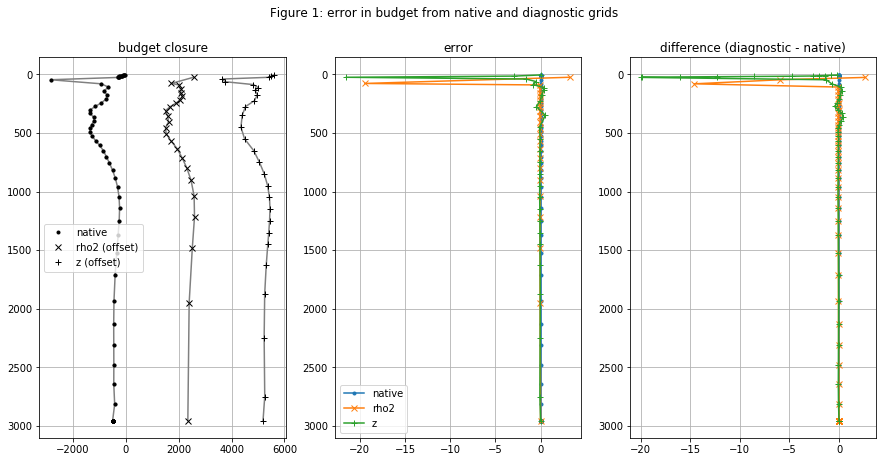

In [62]:
fig, ax = plt.subplots(figsize=(15,7),ncols=3)
fig.suptitle('Figure 1: error in budget from native and diagnostic grids')
# Plot the variable from the native grid, from the diagnostic grid,
# and from the diagnostic grid interpolated onto the native grid
var='tendsum'
max_native = np.max(np.fabs(prof_intz_native[var]))
max_rho2 = np.max(np.fabs(prof_intz_rho2[var]))
max_z = np.max(np.fabs(prof_intz_z[var]))
offset = np.max([max_native, max_rho2, max_z])
ax[0].plot(prof_intz_native[var],prof_intz_native.thkcello,color='gray',marker='.')
ax[0].plot(prof_intz_rho2[var]+offset,prof_intz_rho2.thkcello,color='gray',marker='')
ax[0].plot(prof_intz_z[var]+2*offset,prof_intz_z.thkcello,color='gray',marker='')

var=tend
ax[0].plot(prof_intz_native[var],prof_intz_native.thkcello,color='black',marker='.',linestyle='',label='native')
ax[0].plot(prof_intz_rho2[var]+offset,prof_intz_rho2.thkcello,color='black',marker='x',linestyle='',label='rho2 (offset)')
ax[0].plot(prof_intz_z[var]+2*offset,prof_intz_z.thkcello,color='black',marker='+',linestyle='',label='z (offset)')
ax[0].invert_yaxis()
ax[0].grid()
ax[0].legend()
ax[0].set_title('budget closure')

var='error'
ax[1].plot(prof_intz_native[var],prof_intz_native.thkcello,marker='.',label='native')
ax[1].plot(prof_intz_rho2[var],prof_intz_rho2.thkcello,marker='x',label='rho2')
ax[1].plot(prof_intz_z[var],prof_intz_z.thkcello,marker='+',label='z')
#ax[1].plot(prof_intz_rho2_on_native[var],prof_intz_rho2_on_native.thkcello,marker='1',label='rho2_on_native')
ax[1].invert_yaxis()
ax[1].grid()
ax[1].legend()
ax[1].set_title(var)

ax[2].plot(prof_intz_native[var].values-prof_intz_native[var].values,prof_intz_native.thkcello,marker='.')
ax[2].plot(prof_intz_rho2_on_native[var].values-prof_intz_native[var].values,prof_intz_native.thkcello,marker='x')
ax[2].plot(prof_intz_z_on_native[var].values-prof_intz_native[var].values,prof_intz_native.thkcello,marker='+')
ax[2].invert_yaxis()
ax[2].grid()
ax[2].set_title('difference (diagnostic - native)');

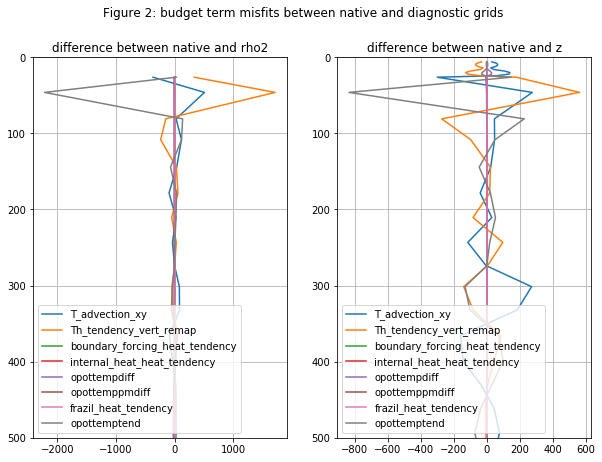

In [66]:
# Determine which terms the difference comes from
fig,ax = plt.subplots(figsize=(10,7),ncols=2)
fig.suptitle('Figure 2: budget term misfits between native and diagnostic grids')
diff_tot_rho2 = np.zeros(shape=prof_intz_native.zl.values.shape)
diff_tot_z = np.zeros(shape=prof_intz_native.zl.values.shape)
for var in terms+[tend]:
    if var==tend:
        sign = -1
    else:
        sign=1
    diff_rho2 = prof_intz_rho2_on_native[var].values-prof_intz_native[var].values
    diff_z = prof_intz_z_on_native[var].values-prof_intz_native[var].values
    ax[0].plot(sign*diff_rho2,prof_intz_native.thkcello,label=var)
    ax[1].plot(sign*diff_z,prof_intz_native.thkcello,label=var)
    diff_tot_rho2 += sign*diff_rho2
    diff_tot_z += sign*diff_z
ax[0].set_ylim([0,500])
ax[0].invert_yaxis()
ax[0].grid()
ax[0].legend(loc='lower left')
ax[0].set_title('difference between native and rho2');
ax[1].set_ylim([0,500])
ax[1].invert_yaxis()
ax[1].grid()
ax[1].legend(loc='lower left')
ax[1].set_title('difference between native and z');

#### Global layer-wise integral
Note that here, the y-axis can't be interpreted as "depth". Rather it is the volume of the ocean occupied by each layer, organised as a cumulative integral (top to bottom). This is a fair comparison between the two grids as it is evaluating the extent to which the budget is closed over an equivalent volume of the ocean, even if the volume does not occupy the exact same space (just as in the case for depth).

In [67]:
# Reduce to single profile, either by selecting one, or by integrating in x and y
integrated = True
if integrated:
    prof_native = (ds_native*grid.areacello).sum(dim=['xh','yh']).squeeze()
    prof_rho2 = (ds_rho2*grid.areacello).sum(dim=['xh','yh']).squeeze()
    prof_z = (ds_z*grid.areacello).sum(dim=['xh','yh']).squeeze()
else:
    prof_native = ds_native.sel(xh=-200,yh=20,method='nearest').squeeze()
    prof_rho2 = ds_rho2.sel(xh=-200,yh=20,method='nearest').squeeze()
    prof_z = ds_z.sel(xh=-200,yh=20,method='nearest').squeeze()

In [68]:
# Calculate cumulative sums in vertical dimension for all dataset
prof_intz_native = prof_native.cumsum(dim='zl')
# Keep only non-zero thickness layers in diagnostic grid
prof_intz_rho2 = prof_rho2.cumsum(dim='rho2_l').where(prof_rho2.thkcello!=0,drop=True)
prof_intz_z = prof_z.cumsum(dim='z_l').where(~np.isnan(prof_z.thkcello),drop=True)
# Create a dataset with diagnostic grid interpolated onto native grid
# Make cumulative thickness the vertical coordinate, then interpolate onto cumulative thickness of native grid
prof_intz_rho2_on_native = prof_intz_rho2.assign_coords(rho2_l=prof_intz_rho2.thkcello).interp(rho2_l=prof_intz_native.thkcello,method='linear')
prof_intz_z_on_native = prof_intz_z.assign_coords(z_l=prof_intz_z.thkcello).interp(z_l=prof_intz_native.thkcello,method='linear')

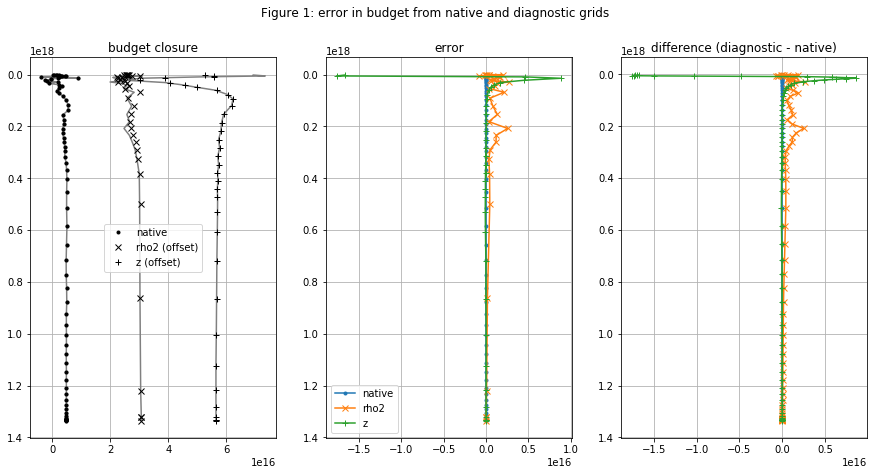

In [69]:
fig, ax = plt.subplots(figsize=(15,7),ncols=3)
fig.suptitle('Figure 1: error in budget from native and diagnostic grids')
# Plot the variable from the native grid, from the diagnostic grid,
# and from the diagnostic grid interpolated onto the native grid
var='tendsum'
max_native = np.max(np.fabs(prof_intz_native[var]))
max_rho2 = np.max(np.fabs(prof_intz_rho2[var]))
max_z = np.max(np.fabs(prof_intz_z[var]))
offset = np.max([max_native, max_rho2, max_z])
ax[0].plot(prof_intz_native[var],prof_intz_native.thkcello,color='gray',marker='.')
ax[0].plot(prof_intz_rho2[var]+offset,prof_intz_rho2.thkcello,color='gray',marker='')
ax[0].plot(prof_intz_z[var]+2*offset,prof_intz_z.thkcello,color='gray',marker='')

var=tend
ax[0].plot(prof_intz_native[var],prof_intz_native.thkcello,color='black',marker='.',linestyle='',label='native')
ax[0].plot(prof_intz_rho2[var]+offset,prof_intz_rho2.thkcello,color='black',marker='x',linestyle='',label='rho2 (offset)')
ax[0].plot(prof_intz_z[var]+2*offset,prof_intz_z.thkcello,color='black',marker='+',linestyle='',label='z (offset)')
ax[0].invert_yaxis()
ax[0].grid()
ax[0].legend()
ax[0].set_title('budget closure')

var='error'
ax[1].plot(prof_intz_native[var],prof_intz_native.thkcello,marker='.',label='native')
ax[1].plot(prof_intz_rho2[var],prof_intz_rho2.thkcello,marker='x',label='rho2')
ax[1].plot(prof_intz_z[var],prof_intz_z.thkcello,marker='+',label='z')
#ax[1].plot(prof_intz_rho2_on_native[var],prof_intz_rho2_on_native.thkcello,marker='1',label='rho2_on_native')
ax[1].invert_yaxis()
ax[1].grid()
ax[1].legend()
ax[1].set_title(var)

ax[2].plot(prof_intz_native[var].values-prof_intz_native[var].values,prof_intz_native.thkcello,marker='.')
ax[2].plot(prof_intz_rho2_on_native[var].values-prof_intz_native[var].values,prof_intz_native.thkcello,marker='x')
ax[2].plot(prof_intz_z_on_native[var].values-prof_intz_native[var].values,prof_intz_native.thkcello,marker='+')
ax[2].invert_yaxis()
ax[2].grid()
ax[2].set_title('difference (diagnostic - native)');

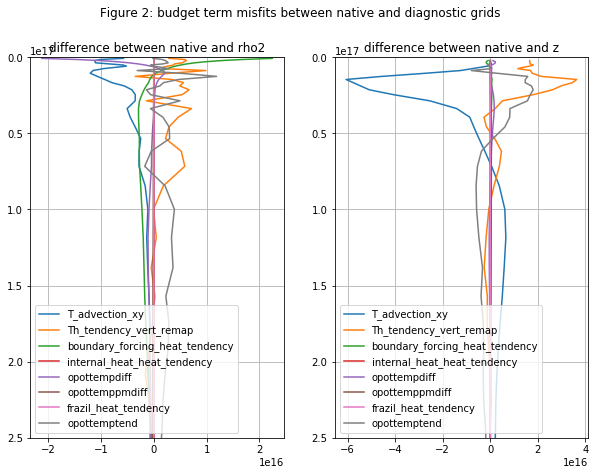

In [70]:
# Determine which terms the difference comes from
fig,ax = plt.subplots(figsize=(10,7),ncols=2)
fig.suptitle('Figure 2: budget term misfits between native and diagnostic grids')
diff_tot_rho2 = np.zeros(shape=prof_intz_native.zl.values.shape)
diff_tot_z = np.zeros(shape=prof_intz_native.zl.values.shape)
for var in terms+[tend]:
    if var==tend:
        sign = -1
    else:
        sign=1
    diff_rho2 = prof_intz_rho2_on_native[var].values-prof_intz_native[var].values
    diff_z = prof_intz_z_on_native[var].values-prof_intz_native[var].values
    ax[0].plot(sign*diff_rho2,prof_intz_native.thkcello,label=var)
    ax[1].plot(sign*diff_z,prof_intz_native.thkcello,label=var)
    diff_tot_rho2 += sign*diff_rho2
    diff_tot_z += sign*diff_z
ax[0].set_ylim([0,0.25E18])
ax[0].invert_yaxis()
ax[0].grid()
ax[0].legend(loc='lower left')
ax[0].set_title('difference between native and rho2');
ax[1].set_ylim([0,0.25E18])
ax[1].invert_yaxis()
ax[1].grid()
ax[1].legend(loc='lower left')
ax[1].set_title('difference between native and z');

### Where do the errors in the regridded budgets arise?
Evaluate and visualise the root sum of squares of error for each profile.

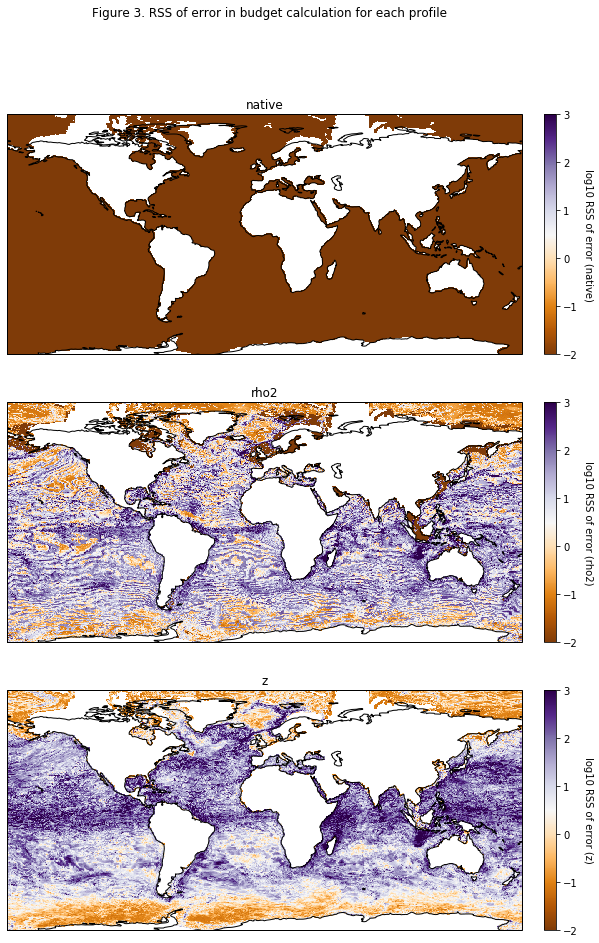

In [38]:
var = 'error'
ds_native_rms = xr.ufuncs.sqrt((ds_native[var]**2).sum(dim='zl'))
ds_z_rms = xr.ufuncs.sqrt((ds_z[var]**2).sum(dim='z_l'))
ds_rho2_rms = xr.ufuncs.sqrt((ds_rho2[var]**2).sum(dim='rho2_l'))
ds_z_rms = xr.ufuncs.sqrt((ds_z[var]**2).sum(dim='z_l'))

fig,ax = plt.subplots(figsize=(10,15),nrows=3,subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle('Figure 3. RSS of error in budget calculation for each profile')

ax[0].coastlines()
ax[0].set_title('native')
im = ax[0].pcolormesh(
    ds_native_rms.xh,ds_native_rms.yh,np.log10(ds_native_rms),
    vmin=-2,vmax=3,cmap='PuOr')
cbar = plt.colorbar(im,ax=ax[0],fraction=0.025,pad=0.04);
cbar.set_label('log10 RSS of error (native)',rotation=270,labelpad=15)

ax[1].coastlines()
ax[1].set_title('rho2')
im = ax[1].pcolormesh(
    ds_rho2_rms.xh,ds_rho2_rms.yh,np.log10(ds_rho2_rms),
    vmin=-2,vmax=3,cmap='PuOr')
cbar = plt.colorbar(im,ax=ax[1],fraction=0.025,pad=0.04);
cbar.set_label('log10 RSS of error (rho2)',rotation=270,labelpad=15)

ax[2].coastlines()
ax[2].set_title('z')
im = ax[2].pcolormesh(
    ds_z_rms.xh,ds_z_rms.yh,np.log10(ds_z_rms),
    vmin=-2,vmax=3,cmap='PuOr')
cbar = plt.colorbar(im,ax=ax[2],fraction=0.025,pad=0.04);
cbar.set_label('log10 RSS of error (z)',rotation=270,labelpad=15)

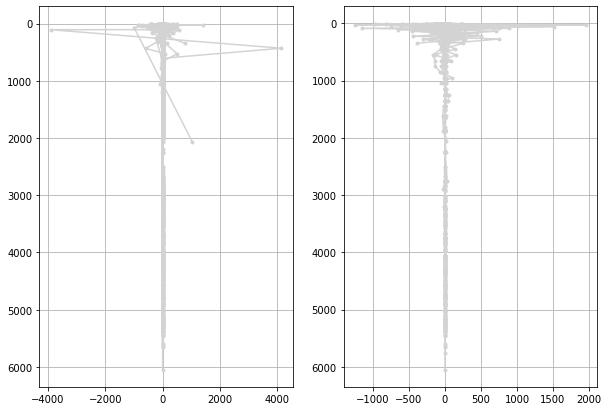

In [6]:
var = 'error'
lons = np.arange(-180,180,10)
lats = np.arange(-90,90,10)
fig,ax = plt.subplots(figsize=(10,7),ncols=2)
for i in lons:
    for j in lats:
        prof_rho2 = ds_rho2.sel(xh=i,yh=j,method='nearest').squeeze()
        if np.where(~np.isnan(prof_rho2[var]))[0].size != 0:
            z = prof_rho2.thkcello.cumsum(dim='rho2_l').where(prof_rho2.thkcello!=0,drop=True)
            v = prof_rho2[var].where(prof_rho2.thkcello!=0,drop=True)
            ax[0].plot(v,z,color='lightgray',marker='.')
            
        prof_z = ds_z.sel(xh=i,yh=j,method='nearest').squeeze()
        if np.where(~np.isnan(prof_z[var]))[0].size != 0:
            z = prof_z.thkcello.cumsum(dim='z_l').where(prof_z.thkcello!=0,drop=True)
            v = prof_z[var].where(prof_z.thkcello!=0,drop=True)
            ax[1].plot(v,z,color='lightgray',marker='.')
ax[0].invert_yaxis()
ax[0].grid()
ax[1].invert_yaxis()
ax[1].grid()

### Do the errors get larger as the averaging window increases?